## Data Transformation

Before training the predictive models, the data needs to be transformed. This first section of the notebook is therefore necessary to load the data and bring it into the desired shape.


As always, the python packages are imported first:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

# various sklearn tools 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import sklearn.preprocessing as pp
from sklearn.preprocessing import OneHotEncoder

# Classifiers
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression #for LASSO
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

The following chunk loads the data and prints the dimensions of the various datasets. Throughout this notebook, we will use the following abbreviations for the datasets:

* median: &emsp;&emsp;  median imputed values
* median_no: &nbsp; median imputed values, removed equity premium outliers
* econ: &emsp;&emsp;&emsp;  median imputed values, removed equity premium outliers, economic indicators added
* iter: &emsp;&emsp;&emsp;&emsp;  values imputed with the iterative imputer


Note, that the first and last dataset both have more observations because the equity premium outliers are still included. One an also see, that data_econ has exactly four more variables, these are obviously the four added economic indicators.

In [2]:
data_median = pd.read_csv("dataset/data_median.csv", index_col=0)
data_median_no = pd.read_csv("dataset/data_median_no.csv", index_col=0)
data_econ = pd.read_csv("dataset/data_econ.csv", index_col=0)
data_iter = pd.read_csv("dataset/data_iter.csv", index_col=0)

print(data_median.shape)
print(data_median_no.shape)
print(data_econ.shape)
print(data_iter.shape)

(19796, 176)
(19595, 176)
(19595, 180)
(19796, 176)


The following chunk splits all the datasets into the y and x. y contains "premium" and "Class" which will both be the response variables, "premium" for regression settings, "Class" for classification algorithms. In this step, we also use `get_dummies()` on the x data to code the "Sector" variable as a categorical feature.

In [3]:
y_median = data_median[["premium", "Class", "Year"]] 
x_median = pd.get_dummies(data_median.drop(["premium", "Class"], axis=1))

y_median_no = data_median_no[["premium", "Class", "Year"]]
x_median_no = pd.get_dummies(data_median_no.drop(["premium", "Class"], axis=1))

y_econ = data_econ[["premium", "Class", "Year"]]
x_econ = pd.get_dummies(data_econ.drop(["premium", "Class"], axis=1))

y_iter = data_iter[["premium", "Class", "Year"]]
x_iter = pd.get_dummies(data_iter.drop(["premium", "Class"], axis=1))

In the following chunk, we standardize and split the x and y variables for each of the different datasets into a x_train, y_train and x_test, y_test. In this case, we do not split the data randomly, but we select all the data for 2018, the last year, as the test set and the previous years data are used for training. After splitting the data, we also drop the "Year" variable from all the feature and response sets as it will not be needed anymore. 

In [4]:
#train-test-split

#train data:
y_median_train = y_median[y_median["Year"] != 2018].drop("Year", axis=1)
x_median_train = x_median[x_median["Year"] != 2018].drop("Year", axis=1)

y_median_no_train = y_median_no[y_median_no["Year"] != 2018].drop("Year", axis=1)
x_median_no_train = x_median_no[x_median_no["Year"] != 2018].drop("Year", axis=1)

y_econ_train = y_econ[y_econ["Year"] != 2018].drop("Year", axis=1)
x_econ_train = x_econ[x_econ["Year"] != 2018].drop("Year", axis=1)

y_iter_train = y_iter[y_iter["Year"] != 2018].drop("Year", axis=1)
x_iter_train = x_iter[x_iter["Year"] != 2018].drop("Year", axis=1)

# test data:
y_median_test = y_median[y_median["Year"] == 2018].drop("Year", axis=1)
x_median_test = x_median[x_median["Year"] == 2018].drop("Year", axis=1)

y_median_no_test = y_median_no[y_median_no["Year"] == 2018].drop("Year", axis=1)
x_median_no_test = x_median_no[x_median_no["Year"] == 2018].drop("Year", axis=1)

y_econ_test = y_econ[y_econ["Year"] == 2018].drop("Year", axis=1)
x_econ_test = x_econ[x_econ["Year"] == 2018].drop("Year", axis=1)

y_iter_test = y_iter[y_iter["Year"] == 2018].drop("Year", axis=1)
x_iter_test = x_iter[x_iter["Year"] == 2018].drop("Year", axis=1)


Now, we need to standardize the features. As explained in the previous notebook, this step is necessary because the financial indicators in the x sets live on different scales. Therefore, standardization avoids that features which consist of higher numbers have an unreasonably high impact on the models. To determine the amount of standardization, we  fit the `StandardScaler()` using the training data and only then use this information to transform the test data. This is needed to avoid a contamination of the training data with information from the test sets.

In [5]:
# Standardize the features

X_train = [x_median_train, x_median_no_train, x_econ_train, x_iter_train]
X_test = [x_median_test, x_median_no_test, x_econ_test, x_iter_test]

for i in range(len(X_train)):
    # Get cols to scale
    cols_scl = X_train[i].columns.values[0:-11]
    # save row and column indices 
    col = X_train[i].columns.values
    ind1 = list(X_train[i].index)
    ind2 = list(X_test[i].index)
    # Apply StandardScaler on numeric columns only
    stdsc = StandardScaler()
    X_train[i][cols_scl] = stdsc.fit_transform(X_train[i][cols_scl])
    # fit & transform
    X_test[i][cols_scl] = stdsc.transform(X_test[i][cols_scl]) # ONLY transform
    # get row and column indices back
    X_train[i] = pd.DataFrame(X_train[i], columns = col, index = ind1)
    X_test[i] = pd.DataFrame(X_test[i], columns = col, index = ind2)


# update the feature matrices:
x_median_train = X_train[0]
x_median_no_train = X_train[1]
x_econ_train = X_train[2]
x_iter_train = X_train[3]

x_median_test = X_test[0]
x_median_no_test = X_test[1]
x_econ_test = X_test[2]
x_iter_test = X_test[3]



The data is now in the desired form an can be easily used to train and test the predictive models in the following part.

## Fitting and testing the predictive models

### 1. Multiple Linear Regression

The first and also the conceptually easiest model to fit is the Multiple Linear Regression model. For its simplicity, the model relies on the following assumptions:

* Linear relationship between features and response
* Normality of the errors 
* Homoscedasticity (constant variance of errors)
* No autocorrelation of the errors
* No multicollinearity in the features

These assumptions are quite strict and often violated in real world applications. Especially the last condition will probably not be fulfilled as we have already seen in the PCA plots in the first notebook that there are some features that can be constructed using linear combinations of other variables. Hence, multicollinearity will probably lead to higher standard errors for the coefficients in the linear regression. Additionally, multiple linear regression is sensitive to outliers, hence we expect that the models on data with removed equity premium outliers will perform better.

The following code will fit the regression models on all of the features in the respective datasets. In this case, we use "premium" as the response variable as we are in a regression setting. Hence, the model will predict the equity premium of the shares in the test sets. 

In [6]:
# Run regressions
mlReg_median = sm.OLS(endog=y_median_train["premium"], exog=sm.add_constant(x_median_train)).fit()
mlReg_median_no = sm.OLS(endog=y_median_no_train["premium"], exog=sm.add_constant(x_median_no_train)).fit()
mlReg_econ = sm.OLS(endog=y_econ_train["premium"], exog=sm.add_constant(x_econ_train)).fit()
mlReg_iter = sm.OLS(endog=y_iter_train["premium"], exog=sm.add_constant(x_iter_train)).fit()

# predict the equity premium for the shares in the test sets for the 3 types of imputed data
predictions_median = mlReg_median.predict(sm.add_constant(x_median_test))
predictions_median_no = mlReg_median_no.predict(sm.add_constant(x_median_no_test))
predictions_econ = mlReg_econ.predict(sm.add_constant(x_econ_test, has_constant='add'))
predictions_iter = mlReg_iter.predict(sm.add_constant(x_iter_test))

To get the investment recommendation classes, we therefore need to use the predicted premiums to assign each share the predicted class label. The following code chunk first iterates through each of the models (for the median, median_no, econ and iter data) and then through each of the shares in each model. This step will be done twice, once for the train set and once for the test set.

In [7]:
# we will here overwrite the tables with every loop. Because of this, python will print out a warning considering 
# chained assignment. As this is exactly what we want in this case, the following line will enable this type of warning.
pd.options.mode.chained_assignment = None

# premium redictions for the train sets
pred_train = [mlReg_median.fittedvalues, mlReg_median_no.fittedvalues, mlReg_econ.fittedvalues, mlReg_iter.fittedvalues]
# true premiums the train sets
y_train = [y_median_train, y_median_no_train, y_econ_train, y_iter_train]

for i in range(len(pred_train)): #iterate over the median, median_no and econ
    pred_train[i] = pd.DataFrame(pred_train[i], columns= ["return"])
    pred_train[i]["Class"] = None  
    # predict the stock classes
    for j in range(pred_train[i].shape[0]): #iterate over the shares
        if pred_train[i]["return"][j] > 2.5:
            pred_train[i]["Class"][j] = 'buy'
        elif pred_train[i]["return"][j] < -2.5:
            pred_train[i]["Class"][j] = 'sell'
        else:
            pred_train[i]["Class"][j] = 'hold'
    # true stock classes        
    pred_train[i]["real_Class"] = list(y_train[i]["Class"])

# premium redictions for the test sets
pred_test = [predictions_median, predictions_median_no, predictions_econ, predictions_iter]
# true premiums the test sets
y_test = [y_median_test, y_median_no_test, y_econ_test, y_iter_test]

for i in range(len(pred_test)): #iterate over the median, median_no and econ
    pred_test[i] = pd.DataFrame(pred_test[i], columns= ["return"])
    pred_test[i]["Class"] = None  
    # predict the stock classes
    for j in range(pred_test[i].shape[0]): #iterate over the shares
        if pred_test[i]["return"][j] > 2.5:
            pred_test[i]["Class"][j] = 'buy'
        elif pred_test[i]["return"][j] < -2.5:
            pred_test[i]["Class"][j] = 'sell'
        else:
            pred_test[i]["Class"][j] = 'hold'
    # true stock classes           
    pred_test[i]["real_Class"] = list(y_test[i]["Class"])

In [8]:
# median imputed values
train_score = accuracy_score(y_true = pred_train[0]["real_Class"], y_pred = pred_train[0]["Class"])
test_score = accuracy_score(y_true = pred_test[0]["real_Class"], y_pred = pred_test[0]["Class"])

print("median imputer")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# median imputed values, removed equity premium outliers
train_score = accuracy_score(y_true = pred_train[1]["real_Class"], y_pred = pred_train[1]["Class"])
test_score = accuracy_score(y_true = pred_test[1]["real_Class"], y_pred = pred_test[1]["Class"])

print("median imputer, removed equity premium outliers")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# median imputed values, removed equity premium outliers, economic indicators added
train_score = accuracy_score(y_true = pred_train[2]["real_Class"], y_pred = pred_train[2]["Class"])
test_score = accuracy_score(y_true = pred_test[2]["real_Class"], y_pred = pred_test[2]["Class"])

print("median imputer, removed equity premium outliers, economic indicators added")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# iteratively imputed values
train_score = accuracy_score(y_true = pred_train[3]["real_Class"], y_pred = pred_train[3]["Class"])
test_score = accuracy_score(y_true = pred_test[3]["real_Class"], y_pred = pred_test[3]["Class"])

print("iterative imputer")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

median imputer
train score:	 0.4563
test score:	 0.4743 
----------------------------------------
median imputer, removed equity premium outliers
train score:	 0.3970
test score:	 0.3981 
----------------------------------------
median imputer, removed equity premium outliers, economic indicators added
train score:	 0.4919
test score:	 0.5911 
----------------------------------------
iterative imputer
train score:	 0.4649
test score:	 0.4477 
----------------------------------------


In the code chunk above, we outlined the classification accuracies for every regression model. We can see, that for the first two models and for the last one, the train and test scores are very close to each other whereas the scores in the third model differs by almost 10%. Surprisingly, the test data in the third model managed to achieve a much higher score than the train data. 

When comparing the models for the scores on the different datasets with each other, we realize that there are high differences in the classification accuracies. We can see that the median imputed data and the iteratively imputed data yielded models which resulted in similar accuracies, but the model for the median imputed data has a higher test score. Notable is also the circumstance, that other than expected, the model on the median imputed data with removed premium outliers performed much worse than the linear models on the datasets with outliers, namely the first and last model. A possible reason may be, that too many observations with high equity premium were removed. However, removing these outliers but enriching the data with macroeconomic indicators enhanced the performance of the multiple regression model remarkably. The test score for the third model reached 59.11% of accuracy which is almost double of the score if we would randomly assign the shares to a class (33.33%). Hence, the third model seems to have some skill in predicting the class variables.

As we already remarked, there is some multicollinearity in the data which needs to be taken into account. One possible method would be to compute the Variance Inflation Factor (VIF) for each of the variables, remove variables with high VIF scores and then to refit each of the models. For this case study however, we choose another method to deal with the large covariate matrices: **shrinkage**.

### 2. Ridge Regression

The Ridge and the Lasso regression are so-called shrinkage methods. They shrink the regression coefficients towards zero by imposing a penalty term. Recall that standard linear regression has no such penalty term. The main goal of these shrinkage methods is to improve prediction accuracy. Shrinkage is extensively used if covariates of the input matrix may not add much value to the prediction as in our case with multicollinear columns in the covariate matrices.

In this section, we use a RidgeClassifier which relies on Ridge Regression performed on the Class labels. This classifier converts the Classes into a regression problem to predict the classes.

Before fitting the model, we will do a grid search to find the optimal alpha for all models for the respective datasets.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange

ridge_model = RidgeClassifier(random_state=89, tol = 0.001)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(ridge_model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_median = search.fit(x_median_train, y_median_train['Class'])
search = GridSearchCV(ridge_model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_median_no = search.fit(x_median_no_train, y_median_no_train['Class'])
search = GridSearchCV(ridge_model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_econ = search.fit(x_econ_train, y_econ_train['Class'])
search = GridSearchCV(ridge_model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_iter = search.fit(x_iter_train, y_iter_train['Class'])

# summarize
print('Accuracy Median Dataset: %.3f' % results_median.best_score_)
print('Config Median Dataset: %s' % results_median.best_params_)

print('Accuracy Median Dataset (No Outliers): %.3f' % results_median_no.best_score_)
print('Config Median Dataset (No Outliers): %s' % results_median_no.best_params_)

print('Accuracy Econ Dataset: %.3f' % results_econ.best_score_)
print('Config Econ Dataset: %s' % results_econ.best_params_)

print('Accuracy Iter Dataset: %.3f' % results_iter.best_score_)
print('Config Iter Dataset: %s' % results_iter.best_params_)

optimal_alpha_median = results_median.best_params_["alpha"]
optimal_alpha_median_no = results_median_no.best_params_["alpha"]
optimal_alpha_econ = results_econ.best_params_["alpha"]
optimal_alpha_iter = results_iter.best_params_["alpha"]

Accuracy Median Dataset: 0.538
Config Median Dataset: {'alpha': 0.24}
Accuracy Median Dataset (No Outliers): 0.543
Config Median Dataset (No Outliers): {'alpha': 0.78}
Accuracy Econ Dataset: 0.582
Config Econ Dataset: {'alpha': 0.99}
Accuracy Iter Dataset: 0.543
Config Iter Dataset: {'alpha': 0.0}


Above, we listed the best cross-validated accuracies of the respective models using the best parameter. Now, we will use these optimal parameters derived from the cross-validation to fit the models and predict the classes.

In [10]:
# fit the RidgeClassifier on the different datasets

# median imputed values
ridge_median = RidgeClassifier(alpha=optimal_alpha_median, random_state = 89)
ridge_median.fit(x_median_train, y_median_train["Class"])

# median imputed values, removed equity premium outliers
ridge_median_no = RidgeClassifier(alpha=optimal_alpha_median_no, random_state = 89)
ridge_median_no.fit(x_median_no_train, y_median_no_train["Class"])

# median imputed values, removed equity premium outliers, economic indicators added
ridge_econ = RidgeClassifier(alpha=optimal_alpha_econ, random_state = 89)
ridge_econ.fit(x_econ_train, y_econ_train["Class"])

ridge_iter = RidgeClassifier(alpha=optimal_alpha_iter, random_state = 89)
ridge_iter.fit(x_iter_train, y_iter_train["Class"])


RidgeClassifier(alpha=0.0, random_state=89)

In [11]:
# compute the accuracy scores for the train and test data of each imputing method

# median imputed values
train_score =  ridge_median.score(x_median_train, y_median_train["Class"])
test_score =  ridge_median.score(x_median_test, y_median_test["Class"])
print("median imputer")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# median imputed values, removed equity premium outliers
train_score =  ridge_median_no.score(x_median_no_train, y_median_no_train["Class"])
test_score =  ridge_median_no.score(x_median_no_test, y_median_no_test["Class"])
print("median imputer, removed equity premium outliers")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# median imputed values, removed equity premium outliers, economic indicators added
train_score =  ridge_econ.score(x_econ_train, y_econ_train["Class"])
test_score =  ridge_econ.score(x_econ_test, y_econ_test["Class"])
print("median imputer, removed equity premium outliers, economic indicators added")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# iteratively imputed values
train_score =  ridge_iter.score(x_iter_train, y_iter_train["Class"])
test_score =  ridge_iter.score(x_iter_test, y_iter_test["Class"])
print("iterative imputer")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

median imputer
train score:	 0.5468
test score:	 0.5446 
----------------------------------------
median imputer, removed equity premium outliers
train score:	 0.5517
test score:	 0.5523 
----------------------------------------
median imputer, removed equity premium outliers, economic indicators added
train score:	 0.5889
test score:	 0.6023 
----------------------------------------
iterative imputer
train score:	 0.5508
test score:	 0.5098 
----------------------------------------


Compared to the Multiple Linear Regression, the RidgeClassifier was able to improve the prediction accuracy on all models. This time, the accuracy scores on the train and test sets are similar throughout all used datasets. Once again, the median imputed data with removed outliers and added economic indicators stands out with the highest prediction accuracy on the test set. We also denote, that the second dataset (median_no) has now a slighty higher score compared to the dataset with included equity premium outliers. Hence removing premium outliers and than also adding economic indicators both improve the performance of this linear model. Here, the model for the iteratively imputed data had the worst accuracy, but still better compared to its score on the linear regression model with no penalty.

### 3. Logistic Regression with Lasso penalty

In this part, we will now use Logistic Regression for the classification problem. To anticipate the issues with multicollinearity, we will also use a shrinking method here: the Lasso penalty. As well as Ridge, Lasso imposes a penalty term on the regression coefficients. Other than Ridge, Lasso regression can set covariates to zero, thus completely ignoring them in the regression. Once again, we start wich a grid search to determine an optimal penalty parameter for the respective models.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange

log = LogisticRegression(penalty = "l1", random_state=123, solver = "saga", max_iter = 3000, tol = 0.001)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['C'] = arange(0.1, 1, 5)
# define search
search = GridSearchCV(log, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_median = search.fit(x_median_train, y_median_train['Class'])
search = GridSearchCV(log, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_median_no = search.fit(x_median_no_train, y_median_no_train['Class'])
search = GridSearchCV(log, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_econ = search.fit(x_econ_train, y_econ_train['Class'])
search = GridSearchCV(log, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_iter = search.fit(x_iter_train, y_iter_train['Class'])

# summarize
print('Accuracy Median Dataset: %.3f' % results_median.best_score_)
print('Config Median Dataset: %s' % results_median.best_params_)

print('Accuracy Median Dataset (No Outliers): %.3f' % results_median_no.best_score_)
print('Config Median Dataset (No Outliers): %s' % results_median_no.best_params_)

print('Accuracy Econ Dataset: %.3f' % results_econ.best_score_)
print('Config Econ Dataset: %s' % results_econ.best_params_)

print('Accuracy Iter Dataset: %.3f' % results_iter.best_score_)
print('Config Iter Dataset: %s' % results_iter.best_params_)

optimal_C_median = results_median.best_params_["C"]
optimal_C_median_no = results_median_no.best_params_["C"]
optimal_C_econ = results_econ.best_params_["C"]
optimal_C_iter = results_iter.best_params_["C"]

Accuracy Median Dataset: 0.539
Config Median Dataset: {'C': 0.1}
Accuracy Median Dataset (No Outliers): 0.543
Config Median Dataset (No Outliers): {'C': 0.1}
Accuracy Econ Dataset: 0.585
Config Econ Dataset: {'C': 0.1}
Accuracy Iter Dataset: 0.540
Config Iter Dataset: {'C': 0.1}


In [13]:
# fit the Logistic Regression on the different datasets

# median imputed values
log_median = LogisticRegression(penalty = "l1", random_state=123, solver = "saga", max_iter = 3000,
                                C = optimal_C_median, tol = 0.001, n_jobs=-1)
log_median.fit(x_median_train, y_median_train["Class"])

# median imputed values, removed equity premium outliers
log_median_no = LogisticRegression(penalty = "l1", random_state=123, solver = "saga", max_iter = 3000,
                                   C = optimal_C_median_no, tol = 0.001, n_jobs=-1)
log_median_no.fit(x_median_no_train, y_median_no_train["Class"])

# median imputed values, removed equity premium outliers, economic indicators added
log_econ = LogisticRegression(penalty = "l1", random_state=123, solver = "saga", max_iter = 3000,
                              C = optimal_C_econ, tol = 0.001, n_jobs=-1)
log_econ.fit(x_econ_train, y_econ_train["Class"])

log_iter = LogisticRegression(penalty = "l1", random_state=123, solver = "saga", max_iter = 3000,
                              C = optimal_C_iter, tol = 0.001, n_jobs=-1)
log_iter.fit(x_iter_train, y_iter_train["Class"])

LogisticRegression(C=0.1, max_iter=3000, n_jobs=-1, penalty='l1',
                   random_state=123, solver='saga', tol=0.001)

In [14]:
# compute the accuracy scores for the train and test data of each imputing method

# median imputed values
train_score =  log_median.score(x_median_train, y_median_train["Class"])
test_score =  log_median.score(x_median_test, y_median_test["Class"])
print("median imputer")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# median imputed values, removed equity premium outliers
train_score =  log_median_no.score(x_median_no_train, y_median_no_train["Class"])
test_score =  log_median_no.score(x_median_no_test, y_median_no_test["Class"])
print("median imputer, removed equity premium outliers")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# median imputed values, removed equity premium outliers, economic indicators added
train_score =  log_econ.score(x_econ_train, y_econ_train["Class"])
test_score =  log_econ.score(x_econ_test, y_econ_test["Class"])
print("median imputer, removed equity premium outliers, economic indicators added")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# iteratively imputed values
train_score =  log_iter.score(x_iter_train, y_iter_train["Class"])
test_score =  log_iter.score(x_iter_test, y_iter_test["Class"])
print("iterative imputer")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")


median imputer
train score:	 0.5460
test score:	 0.5513 
----------------------------------------
median imputer, removed equity premium outliers
train score:	 0.5516
test score:	 0.5584 
----------------------------------------
median imputer, removed equity premium outliers, economic indicators added
train score:	 0.5908
test score:	 0.6060 
----------------------------------------
iterative imputer
train score:	 0.5474
test score:	 0.5475 
----------------------------------------


This classifier yields almost identical, although slightly higher scores on the test sets compared to linear regression with a Ridge penalty. The exception is again the last model which in this case has a similar but still slightly inferior performance as the models for the first two datasets. Once again, the third dataset leads to the highest prediction accuracy. Hence, adding economic data seems to improve the prediction performance of this algorithm as well.

### 4. Linear Discriminant Analysis (LDA)

We will now use a classic LDA to fit and classify the datasets. Here, we will use the "svd" (Singular value decomposition) solver because this is recommended for data with a large number of features as stated in the scikitlearn documentation.

In [15]:
# fit the LDA on the different datasets

# median imputed values
lda_median = LDA(solver='svd')
lda_median.fit(x_median_train, y_median_train["Class"])

# median imputed values, removed equity premium outliers
lda_median_no = LDA(solver='svd')
lda_median_no.fit(x_median_no_train, y_median_no_train["Class"])

# median imputed values, removed equity premium outliers, economic indicators added
lda_econ = LDA(solver='svd')
lda_econ.fit(x_econ_train, y_econ_train["Class"])

# iteratively imputed values
lda_iter = LDA(solver='svd')
lda_iter.fit(x_iter_train, y_iter_train["Class"])

LinearDiscriminantAnalysis()

In [16]:
# compute the accuracy scores for the train and test data of each imputing method

# median imputed values
train_score = lda_median.score(x_median_train, y_median_train["Class"])
test_score = lda_median.score(x_median_test, y_median_test["Class"])
print("median imputer")
print(f'Train Score:\t\t {train_score:.4f}')
print(f'Test Score:\t\t {test_score:.4f}')
print(40*"-")

# median imputed values, removed equity premium outliers
train_score = lda_median_no.score(x_median_no_train, y_median_no_train["Class"])
test_score = lda_median_no.score(x_median_no_test, y_median_no_test["Class"])
print("median imputer, removed equity premium outliers")
print(f'Train Score:\t\t {train_score:.4f}')
print(f'Test Score:\t\t {test_score:.4f}')
print(40*"-")

# median imputed values, removed equity premium outliers, economic indicators added
train_score = lda_econ.score(x_econ_train, y_econ_train["Class"])
test_score = lda_econ.score(x_econ_test, y_econ_test["Class"])
print("median imputer, removed equity premium outliers, economic indicators added")
print(f'Train Score:\t\t {train_score:.4f}')
print(f'Test Score:\t\t {test_score:.4f}')
print(40*"-")

# iteratively imputed values
train_score = lda_iter.score(x_iter_train, y_iter_train["Class"])
test_score = lda_iter.score(x_iter_test, y_iter_test["Class"])
print("iterative imputer")
print(f'Train Score:\t\t {train_score:.4f}')
print(f'Test Score:\t\t {test_score:.4f}')
print(40*"-")

median imputer
Train Score:		 0.5457
Test Score:		 0.5429
----------------------------------------
median imputer, removed equity premium outliers
Train Score:		 0.5509
Test Score:		 0.5501
----------------------------------------
median imputer, removed equity premium outliers, economic indicators added
Train Score:		 0.5870
Test Score:		 0.5999
----------------------------------------
iterative imputer
Train Score:		 0.5472
Test Score:		 0.5093
----------------------------------------


Once again, the results on the test sets are very close to the results from the previous two methods except for the last model which yields a worse test score.

### 5. Quadratic Discriminant Analysis (QDA)

We will now use QDA for this problem. As this method usually upraged the LDA due to the additional consideration of the quadratic term, one would expect that this model is an improvement to the LDA algorithm (Friedman et al. (2001)).

In [17]:
# median imputed values
qda_median = QDA()
qda_median.fit(x_median_train, y_median_train["Class"])

# median imputed values, removed equity premium outliers
qda_median_no = QDA()
qda_median_no.fit(x_median_no_train, y_median_no_train["Class"])

# median imputed values, removed equity premium outliers, economic indicators added
qda_econ = QDA()
qda_econ.fit(x_econ_train, y_econ_train["Class"])

# iteratively imputed values
qda_iter = QDA()
qda_iter.fit(x_iter_train, y_iter_train["Class"])

C:\Users\jorge\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [18]:
# median imputed values
train_score = qda_median.score(x_median_train, y_median_train["Class"])
test_score = qda_median.score(x_median_test, y_median_test["Class"])
print("median imputer")
print(f'Train Score:\t\t {train_score:.4f}')
print(f'Test Score:\t\t {test_score:.4f}')
print(40*"-")

# median imputed values, removed equity premium outliers
train_score = qda_median_no.score(x_median_no_train, y_median_no_train["Class"])
test_score = qda_median_no.score(x_median_no_test, y_median_no_test["Class"])
print("median imputer, removed equity premium outliers")
print(f'Train Score:\t\t {train_score:.4f}')
print(f'Test Score:\t\t {test_score:.4f}')
print(40*"-")

# median imputed values, removed equity premium outliers, economic indicators added
train_score = qda_econ.score(x_econ_train, y_econ_train["Class"])
test_score = qda_econ.score(x_econ_test, y_econ_test["Class"])
print("median imputer, removed equity premium outliers, economic indicators added")
print(f'Train Score:\t\t {train_score:.4f}')
print(f'Test Score:\t\t {test_score:.4f}')
print(40*"-")

# iteratively imputed values
train_score = qda_iter.score(x_iter_train, y_iter_train["Class"])
test_score = qda_iter.score(x_iter_test, y_iter_test["Class"])
print("iterative imputer")
print(f'Train Score:\t\t {train_score:.4f}')
print(f'Test Score:\t\t {test_score:.4f}')
print(40*"-")


median imputer
Train Score:		 0.1416
Test Score:		 0.1135
----------------------------------------
median imputer, removed equity premium outliers
Train Score:		 0.1465
Test Score:		 0.1215
----------------------------------------
median imputer, removed equity premium outliers, economic indicators added
Train Score:		 0.1480
Test Score:		 0.3384
----------------------------------------
iterative imputer
Train Score:		 0.1456
Test Score:		 0.1811
----------------------------------------


Quite surprinsingly, the scores using this method are extremely low compared to the other methods. One would usually expect QDA to perform better than LDA. In this case however, QDA has an even worse performance than randomly guessing the class labes in the first two datasets. The main reason for this poor performance probably is due to the high number of features and the existing multicollinearity. As QDA is more flexible than LDA, it is also more exposed to this issues which lead to very high variances and eventually to a worse prediction accuracy in this case. 

### 6. Random Forest

In the following two sections, we try to predict future performance by using so-called decision trees. A decision tree breaks down complicated, multivariate data by using simple "yes or no" decision rules.

Ever since they were introduced by Leo Breiman in 2001, random forests have been often used and met with approval especially because they can handle complex data and are less prone to overfitting than single decision trees. The idea of random forests is to use bootstrapped samples from the original data (sample from the data with replacement) and then fit a decision tree on each sample. It is important to note that random forests only use a randomly chosen subset of covariates at each split. This is done to decrease correlation between trees. Finally, random forests follow a majority vote principle for classification to choose how to classify each new observation.


For all random forest models, we will do grid search to find optimal hyperparameters. Due to computational limitations, we only consider `n_estimators=100` (for a larger number, the grid search takes up significantly more time). Further, the only parameter we will optimize in the following chunk is the `min_samples_split`. 

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange

rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators = 100,max_depth = 5, max_features = 10)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = {'min_samples_split' : [2, 5, 10]}

search = GridSearchCV(rf, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_median = search.fit(x_median_train, y_median_train['Class'])
search = GridSearchCV(rf, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_median_no = search.fit(x_median_no_train, y_median_no_train['Class'])
search = GridSearchCV(rf, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_econ = search.fit(x_econ_train, y_econ_train['Class'])
search = GridSearchCV(rf, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results_iter = search.fit(x_iter_train, y_iter_train['Class'])


# summarize
print('Accuracy Median Dataset: %.3f' % results_median.best_score_)
print('Config Median Dataset: %s' % results_median.best_params_)

print('Accuracy Median Dataset (No Outliers): %.3f' % results_median_no.best_score_)
print('Config Median Dataset (No Outliers): %s' % results_median_no.best_params_)

print('Accuracy Econ Dataset: %.3f' % results_econ.best_score_)
print('Config Econ Dataset: %s' % results_econ.best_params_)

print('Accuracy Iter Dataset: %.3f' % results_iter.best_score_)
print('Config Iter Dataset: %s' % results_iter.best_params_)

optimal_min_samples_median = results_median.best_params_["min_samples_split"]
optimal_min_samples_median_no = results_median_no.best_params_["min_samples_split"]
optimal_min_samples_econ = results_econ.best_params_["min_samples_split"]
optimal_min_samples_iter = results_iter.best_params_["min_samples_split"]

Accuracy Median Dataset: 0.560
Config Median Dataset: {'min_samples_split': 2}
Accuracy Median Dataset (No Outliers): 0.563
Config Median Dataset (No Outliers): {'min_samples_split': 5}
Accuracy Econ Dataset: 0.611
Config Econ Dataset: {'min_samples_split': 2}
Accuracy Iter Dataset: 0.560
Config Iter Dataset: {'min_samples_split': 10}


In [20]:
# median imputed values
rf_median = RandomForestClassifier(n_estimators = 100, random_state = 42,
                                   n_jobs = -1, min_samples_split = optimal_min_samples_median,max_depth = 5, max_features = 10)
rf_median.fit(x_median_train, y_median_train["Class"])

# median imputed values, removed equity premium outliers
rf_median_no = RandomForestClassifier(n_estimators = 100, random_state = 42,
                                     n_jobs = -1, min_samples_split = optimal_min_samples_median_no,max_depth = 5, max_features = 10)
rf_median_no.fit(x_median_no_train, y_median_no_train["Class"])

# median imputed values, removed equity premium outliers, economic indicators added
rf_econ = RandomForestClassifier(n_estimators = 100, random_state = 42,
                                n_jobs = -1, min_samples_split = optimal_min_samples_econ,max_depth = 5, max_features = 10)
rf_econ.fit(x_econ_train, y_econ_train["Class"])

rf_iter = RandomForestClassifier(n_estimators = 100, random_state = 42,
                                n_jobs = -1, min_samples_split = optimal_min_samples_iter, max_depth = 5, max_features = 10)
rf_iter.fit(x_iter_train, y_iter_train["Class"])


RandomForestClassifier(max_depth=5, max_features=10, min_samples_split=10,
                       n_jobs=-1, random_state=42)

In [21]:
# median imputed values
train_score =  rf_median.score(x_median_train, y_median_train["Class"])
test_score =  rf_median.score(x_median_test, y_median_test["Class"])
print("median imputer")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# median imputed values, removed equity premium outliers
train_score =  rf_median_no.score(x_median_no_train, y_median_no_train["Class"])
test_score =  rf_median_no.score(x_median_no_test, y_median_no_test["Class"])
print("median imputer, removed equity premium outliers")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# median imputed values, removed equity premium outliers, economic indicators added
train_score =  rf_econ.score(x_econ_train, y_econ_train["Class"])
test_score =  rf_econ.score(x_econ_test, y_econ_test["Class"])
print("median imputer, removed equity premium outliers, economic indicators added")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# iteratively imputed values
train_score =  rf_iter.score(x_iter_train, y_iter_train["Class"])
test_score =  rf_iter.score(x_iter_test, y_iter_test["Class"])
print("iterative imputer")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

median imputer
train score:	 0.5861
test score:	 0.5673 
----------------------------------------
median imputer, removed equity premium outliers
train score:	 0.5857
test score:	 0.5714 
----------------------------------------
median imputer, removed equity premium outliers, economic indicators added
train score:	 0.6251
test score:	 0.5631 
----------------------------------------
iterative imputer
train score:	 0.5832
test score:	 0.5646 
----------------------------------------


What we can see here for the first time are some signs of overfitting, as the train scores are mostly higher than the test scores, especially in the third model.  However, the test scores are similar to the ones we received with previous algorithms (except for QDA). Here, the test scores are also very close to each other throughout the different datasets.

### 7. Gradient Boosting

Similar to Random Forests, Gradient Boosing is also a decision tree method. It is part of the family of "Boosting" methods. The basic idea is to start by fitting a basic model and then improve the fits sequentally by focusing on the cases where prediction was poor. Gradient Boosting combines these new models with previous models to minimize overall prediction error. From the theory one would expect Gradient Boosting to perform better than Random Forest (Friedman et al. (2001)).

In [22]:
# median imputed values
gb_median = GradientBoostingClassifier(max_features = 10, learning_rate = 0.001, n_estimators=1000, random_state = 234)
gb_median.fit(x_median_train, y_median_train["Class"])

# median imputed values, removed equity premium outliers
gb_median_no = GradientBoostingClassifier(max_features = 10, learning_rate = 0.001, n_estimators=1000, random_state = 234)
gb_median_no.fit(x_median_no_train, y_median_no_train["Class"])

# median imputed values, removed equity premium outliers, economic indicators added
gb_econ = GradientBoostingClassifier(max_features = 10, learning_rate = 0.001, n_estimators=1000, random_state = 234)
gb_econ.fit(x_econ_train, y_econ_train["Class"])

gb_iter = GradientBoostingClassifier(max_features = 10, learning_rate = 0.001, n_estimators=1000, random_state = 234)
gb_iter.fit(x_iter_train, y_iter_train["Class"])

GradientBoostingClassifier(learning_rate=0.001, max_features=10,
                           n_estimators=1000, random_state=234)

In [23]:
# median imputed values
train_score =  gb_median.score(x_median_train, y_median_train["Class"])
test_score =  gb_median.score(x_median_test, y_median_test["Class"])
print("median imputer")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# median imputed values, removed equity premium outliers
train_score =  gb_median_no.score(x_median_no_train, y_median_no_train["Class"])
test_score =  gb_median_no.score(x_median_no_test, y_median_no_test["Class"])
print("median imputer, removed equity premium outliers")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

# median imputed values, removed equity premium outliers, economic indicators added
train_score =  gb_econ.score(x_econ_train, y_econ_train["Class"])
test_score =  gb_econ.score(x_econ_test, y_econ_test["Class"])
print("median imputer, removed equity premium outliers, economic indicators added")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

#iteratively imputed data
train_score =  gb_iter.score(x_iter_train, y_iter_train["Class"])
test_score =  gb_iter.score(x_iter_test, y_iter_test["Class"])
print("iterative imputer")
print(f"train score:\t {train_score:.4f}")
print(f"test score:\t {test_score:.4f} ")
print(40*"-")

median imputer
train score:	 0.5543
test score:	 0.5781 
----------------------------------------
median imputer, removed equity premium outliers
train score:	 0.5572
test score:	 0.5879 
----------------------------------------
median imputer, removed equity premium outliers, economic indicators added
train score:	 0.5949
test score:	 0.5843 
----------------------------------------
iterative imputer
train score:	 0.5495
test score:	 0.5776 
----------------------------------------


As expected, Gradient Boosting yields (slightly) better results on the test data compared to the Random Forest  classifier. Here, the models also do not overfit the training data as the test data have higher accuracies for the datasets. These test scores are again similar throughout all used models.

### 8. Support Vector Machines
The last method outlined in this case study are Support Vector Machines (SVM). We will use this method rather extensively in the process and try out multiple variations. 

SVM are supervised learning models which we will use to classify our data. Introduced by Vapnik and colleagues in the 1990s (Boser et al. (1992), Guyon et al. (1993) and Vapnik et al. (1997)). We chose to use SVMs as they are shown to be quite robust prediction methods. SVMs can also be used to conduct linear, as well as non-linear prediction. In this notebook, we will apply SVM in many different ways, while integrating different ideas from other algorithms in order to improve perfomance. We start with a simple linear model.

#### 8.1 Data transformation
The next chunks of code use a different transformation of the data as we will use pipelines further below. Hence the data will be reloaded and transformed again.

In [24]:
# median imputed values
data_median = pd.read_csv("dataset\data_median.csv",index_col=0)
datmed14 = data_median[data_median["Year"]==2014]
datmed15 = data_median[data_median["Year"]==2015]
datmed16 = data_median[data_median["Year"]==2016]
datmed17 = data_median[data_median["Year"]==2017]
datmed18 = data_median[data_median["Year"]==2018]

train_median = datmed14.append(datmed15).append(datmed16).append(datmed17)
train_median = train_median.drop(['Year'],axis =1)

num_cols_train_med = train_median.columns[train_median.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

test_median = datmed18
test_median = test_median.drop(["Year"],axis = 1)
num_cols_test_med = test_median.columns[test_median.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

As we only need to standardize numerical columns, we define the numerical columns for all datasets. We also conduct the test-train-split. The dataset for 2018 is the test set, the other datasets combine to the train set.

In [25]:
# median imputed values, removed equity premium outliers
data_median_no = pd.read_csv("dataset\data_median_no.csv",index_col=0)
datmed_no_14 = data_median_no[data_median_no["Year"]==2014]
datmed_no_15 = data_median_no[data_median_no["Year"]==2015]
datmed_no_16 = data_median_no[data_median_no["Year"]==2016]
datmed_no_17 = data_median_no[data_median_no["Year"]==2017]
datmed_no_18 = data_median_no[data_median_no["Year"]==2018]

train_no = datmed_no_14.append(datmed_no_15).append(datmed_no_16).append(datmed_no_17)
train_no = train_no.drop(["Year"], axis = 1)

num_cols_train_no = train_no.columns[train_no.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

test_no = datmed_no_18
test_no = test_no.drop(["Year"],axis = 1)
num_cols_test_no = test_no.columns[test_no.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

In [26]:
# median imputed values, removed equity premium outliers, economic indicators added
data_econ = pd.read_csv("dataset\data_econ.csv",index_col=0)

datecon_14 = data_econ[data_econ["Year"]==2014]
datecon_15 = data_econ[data_econ["Year"]==2015]
datecon_16 = data_econ[data_econ["Year"]==2016]
datecon_17 = data_econ[data_econ["Year"]==2017]
datecon_18 = data_econ[data_econ["Year"]==2018]

train_econ = datecon_14.append(datecon_15).append(datecon_16).append(datecon_17)
train_econ = train_econ.drop(["Year"],axis=1)
num_cols_train_econ = train_econ.columns[train_econ.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

test_econ = datecon_18
test_econ = test_econ.drop(["Year"],axis = 1)
num_cols_test_econ = test_econ.columns[test_econ.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

In [27]:
#iteratively imputed data
data_iter = pd.read_csv("dataset\data_iter.csv", index_col=0)

datiter_14 = data_iter[data_iter["Year"]==2014]
datiter_15 = data_iter[data_iter["Year"]==2015]
datiter_16 = data_iter[data_iter["Year"]==2016]
datiter_17 = data_iter[data_iter["Year"]==2017]
datiter_18 = data_iter[data_iter["Year"]==2018]

train_iter = datiter_14.append(datiter_15).append(datiter_16).append(datiter_17)
train_iter = train_iter.drop(["Year"],axis=1)

num_cols_train_iter = train_iter.columns[train_iter.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

test_iter = datiter_18
test_iter = test_iter.drop(["Year"],axis = 1)
num_cols_test_iter = test_iter.columns[test_iter.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

We now define x and y of the test and train datasets, for the different datasets defined above (median, median_no, econ, iter). Currently, all columns except for "Class" and "premium" are used as x, while "Class" is used as y.

In [28]:
X_trainmit = train_median.drop(["Class","premium"], axis=1)
y_trainmit = train_median["Class"]

X_testmit = test_median.drop(["Class","premium"], axis=1)
y_testmit = test_median["Class"]

X_trainohne = train_no.drop(["Class","premium"], axis=1)
y_trainohne = train_no["Class"]

X_testohne = test_no.drop(["Class","premium"], axis=1)
y_testohne = test_no["Class"]

X_trainecon = train_econ.drop(["Class","premium"], axis=1)
y_trainecon = train_econ["Class"]

X_testecon = test_econ.drop(["Class","premium"], axis=1)
y_testecon = test_econ["Class"]

X_trainiter = train_iter.drop(["Class","premium"], axis=1)
y_trainiter = train_iter["Class"]

X_testiter = test_iter.drop(["Class","premium"],axis=1)
y_testiter = test_iter["Class"]

As SVM are sensitive to the scaling of the data, we use a `StandardScaler()` object to deal with that. However, in order to only standardize numerical data, we use a workaround by defining numeric columns.

In [29]:
#SVM are sensitive to the scale of the data, so I use a StandardScaler() object to deal with that.
sc = StandardScaler() #creating StandardScaler object

X_trainmit_std = sc.fit_transform(X_trainmit[num_cols_train_med.drop("premium")])

X_testmit_std = sc.transform(X_testmit[num_cols_test_med.drop("premium")])

X_trainohne_std = sc.fit_transform(X_trainohne[num_cols_train_no.drop("premium")])

X_testohne_std = sc.transform(X_testohne[num_cols_test_no.drop("premium")])

X_trainecon_std = sc.fit_transform(X_trainecon[num_cols_train_econ.drop("premium")])

X_testecon_std = sc.transform(X_testecon[num_cols_test_econ.drop("premium")])

X_trainiter_std = sc.fit_transform(X_trainiter[num_cols_train_iter.drop("premium")])

X_testiter_std = sc.transform(X_testiter[num_cols_test_iter.drop("premium")])

In [30]:
ohe = pp.OneHotEncoder(sparse=True)

train_median['Sector'] = ohe.fit_transform(train_median[['Sector']])
test_median['Sector'] = ohe.fit_transform(test_median[['Sector']])
train_no['Sector'] = ohe.fit_transform(train_no[['Sector']])
test_no['Sector'] = ohe.fit_transform(test_no[['Sector']])
train_econ['Sector'] = ohe.fit_transform(train_econ[['Sector']])
test_econ['Sector'] = ohe.fit_transform(test_econ[['Sector']])
train_iter['Sector'] = ohe.fit_transform(train_iter[['Sector']])
test_iter['Sector'] = ohe.fit_transform(test_iter[['Sector']])


print(data_median.shape)
print(data_median_no.shape)
print(data_econ.shape)

(19796, 176)
(19595, 176)
(19595, 180)


OneHotEncoder is used to Encode the 'Sector' Variable as a categorical variable, with multiple levels. The chunk above will only work if the chunks above are run in order. As can be seen, the variable 'Sector' will not be used in the model prediction. This is not a major issue as the additional explanatory power of this variable is quite low, as can be seen in the scree plot of the PCA. This was done due to issues with the OneHotEncoder while using SVM().

##### 8.2.1 Linear Kernel

A first attempt at classification is conducted with a linear kernel.

In [31]:
svm_linear = SVC(kernel='linear', C=1.0,random_state=1)
svm_linear

SVC(kernel='linear', random_state=1)

__median imputed values__

In [32]:
svm_linear.fit(X_trainmit_std,y_trainmit)

#printing the results
print("Train score: {:.4f}".format(svm_linear.score(X_trainmit_std,y_trainmit)))#0.53
print("Test score: {:.4f}".format(svm_linear.score(X_testmit_std,y_testmit)))#0.60

Train score: 0.5284
Test score: 0.5989


The first attempt at classification using the dataset which includes outliers, returns a test score of around 0.60. This performance ranks among the better ones until now, but a very large portion of the dataset belongs to one class. The linear kernel SVM does not perform much better than simply guessing the class with the highest occurance. The performance found here however, is extremely stable. 

In [33]:
y_predmit = svm_linear.predict(X_testmit_std)
confm = pd.DataFrame({'Predicted':y_predmit,
                     'True':y_testmit})
confm.replace(to_replace={0:'Sell',1:'Hold',2:'Buy'},inplace=True)
print(confm.groupby(['True','Predicted'],sort=False).size().unstack('Predicted'))

Predicted   buy    sell  hold
True                         
buy        23.0  1405.0   1.0
hold       12.0   206.0   NaN
sell       35.0  2457.0   2.0


Above, we see the confusion matrix of the classification conducted for the dataset with outliers using a linear kernel. We see the instances of correct classification where the description of the row and column correspond. Otherwise, the method missclassified the stock. We repeat the process for the other datasets. The confusion matrix confirms this strong class imbalance, as a few classes dominate the data, while "hold" has very few occurances.

__median imputed values, removed equity premium outliers__

In [34]:
svm_linear.fit(X_trainohne_std,y_trainohne)

#printing the results
print("Train score: {:.4f}".format(svm_linear.score(X_trainohne_std,y_trainohne)))#0.99
print("Test score: {:.4f}".format(svm_linear.score(X_testohne_std, y_testohne)))#0.99

Train score: 0.5337
Test score: 0.6045


In [35]:
y_predohne = svm_linear.predict(X_testohne_std)
confm = pd.DataFrame({'Predicted':y_predohne,
                     'True':y_testohne})
confm.replace(to_replace={0:'Sell',1:'Hold',2:'Buy'},inplace=True)
print(confm.groupby(['True','Predicted'],sort=False).size().unstack('Predicted'))

Predicted   buy    sell  hold
True                         
buy        21.0  1365.0   1.0
hold       11.0   207.0   NaN
sell       35.0  2457.0   2.0


Removing the equity premium outliers has a small positive effect on the test score. Beyond that small change, the same things can be seen here. The performance has still around 0.60 accuracy, and the confusion matrix confirms a large class imbalance. Additionally, we can see that the confusion matrices are very similar and that most of the removed outliers belong to the buy-worthy stocks were predicted as sell worthy in the previous model, hence the small improvement in accuracy.

__median imputed values, removed equity premium outliers, economic indicators added__

In [36]:
svm_linear.fit(X_trainecon_std,y_trainecon)

#printing the results
print("Train score: {:.4f}".format(svm_linear.score(X_trainecon_std,y_trainecon)))#0.99
print("Test score: {:.4f}".format(svm_linear.score(X_testecon_std, y_testecon)))#0.99

Train score: 0.5758
Test score: 0.6055


In [37]:
y_predecon = svm_linear.predict(X_testecon_std)
confm = pd.DataFrame({'Predicted':y_predecon,
                     'True':y_testecon})
confm.replace(to_replace={0:'Sell',1:'Hold',2:'Buy'},inplace=True)
print(confm.groupby(['True','Predicted'],sort=False).size().unstack('Predicted'))

Predicted    sell   buy  hold
True                         
buy        1373.0  13.0   1.0
hold        209.0   9.0   NaN
sell       2469.0  23.0   2.0


Adding economic indicators to the dataset has a very small positive effect on the test score. We would not argue however that this change is significant. It seems unclear whether adding economic indicators improves the test score significantly.

__iteratively imputed data__

In [38]:
svm_linear.fit(X_trainiter_std,y_trainiter)

#printing the results
print("Train score: {:.4f}".format(svm_linear.score(X_trainiter_std,y_trainiter)))
print("Test score: {:.4f}".format(svm_linear.score(X_testiter_std, y_testiter)))

Train score: 0.5298
Test score: 0.5967


In [39]:
y_prediter = svm_linear.predict(X_testiter_std)
confm = pd.DataFrame({'Predicted':y_prediter,
                     'True':y_testiter})
confm.replace(to_replace={0:'Sell',1:'Hold',2:'Buy'},inplace=True)
print(confm.groupby(['True','Predicted'],sort=False).size().unstack('Predicted'))

Predicted   buy    sell  hold
True                         
buy        32.0  1396.0   1.0
hold       15.0   203.0   NaN
sell       44.0  2439.0  11.0


The iterative dataset, has a worse test score than the median imputed dataset we looked at above. This is interesting, as one would assume the more complicated iteratively imputed NaNs would improve performance. However, it seems that the median imputed data performs better than the iterative imputer.

##### 8.2.2 Polynomial Kernel

Polynomial Kernel: We now attempt to conduct classification with a more complex model. The process is very similar to Section 8.2.1 in other aspects.

In [40]:
svm_poly = SVC(kernel="poly", random_state=1)
svm_poly

SVC(kernel='poly', random_state=1)

__median imputed values__

In [41]:
svm_poly.fit(X_trainmit_std, y_trainmit)
#print("Observed probability of non-default: {:2f}"
      #.format(np.count_nonzero(y_train==0)/len(y_train)))
print("Train score: {:.4f}".format(svm_poly.score(X_trainmit_std, y_trainmit)))#0.54
print("Test score: {:.4f}".format(svm_poly.score(X_testmit_std, y_testmit)))#0.59

Train score: 0.5416
Test score: 0.5931


In [42]:
y_predmit_poly = svm_poly.predict(X_testmit_std)
confm = pd.DataFrame({'Predicted':y_predmit_poly,
                     'True':y_testmit})
confm.replace(to_replace={0:'Sell',1:'Hold',2:'Buy'},inplace=True)
print(confm.groupby(['True','Predicted'],sort=False).size().unstack('Predicted'))

Predicted  buy  sell  hold
True                      
buy         21  1402     6
hold        11   205     2
sell        51  2433    10


The main finding of Chapter 8.2.2 is that the polynomial kernel does not clearly improve performance. If anything, the test scores observed for all the datasets are slighlty worse. This clearly shows that the added complexity of the polynomial kernel does not improve performance enough to merit using it. Moreover, performance is still extremely stable and the confusion matricies still show strong class imbalance.

__median imputed values, removed equity premium outliers__

In [43]:
svm_poly.fit(X_trainohne_std, y_trainohne)
#print("Observed probability of non-default: {:2f}"
      #.format(np.count_nonzero(y_train==0)/len(y_train)))
print("Train score: {:.4f}".format(svm_poly.score(X_trainohne_std, y_trainohne)))#0.55
print("Test score: {:.4f}".format(svm_poly.score(X_testohne_std, y_testohne)))#0.60

Train score: 0.5469
Test score: 0.5994


In [44]:
y_predohne_poly = svm_poly.predict(X_testohne_std)
confm = pd.DataFrame({'Predicted':y_predohne_poly,
                     'True':y_testohne})
confm.replace(to_replace={0:'Sell',1:'Hold',2:'Buy'},inplace=True)
print(confm.groupby(['True','Predicted'],sort=False).size().unstack('Predicted'))

Predicted  buy  sell  hold
True                      
buy         21  1360     6
hold        11   205     2
sell        50  2434    10


__median imputed values, removed equity premium outliers, economic indicators added__

In [45]:
svm_poly.fit(X_trainecon_std, y_trainecon)
#print("Observed probability of non-default: {:2f}"
      #.format(np.count_nonzero(y_train==0)/len(y_train)))
print("Train score: {:.4f}".format(svm_poly.score(X_trainecon_std, y_trainecon)))#0.55
print("Test score: {:.4f}".format(svm_poly.score(X_testecon_std, y_testecon)))#0.60

Train score: 0.5490
Test score: 0.5984


In [46]:
y_predecon_poly = svm_poly.predict(X_testecon_std)
confm = pd.DataFrame({'Predicted':y_predecon_poly,
                     'True':y_testohne})
confm.replace(to_replace={0:'Sell',1:'Hold',2:'Buy'},inplace=True)
print(confm.groupby(['True','Predicted'],sort=False).size().unstack('Predicted'))

Predicted  buy  sell  hold
True                      
buy         21  1359     7
hold        12   205     1
sell        52  2431    11


__iteratively imputed data__

In [47]:
svm_poly.fit(X_trainiter_std, y_trainiter)
#print("Observed probability of non-default: {:2f}"
      #.format(np.count_nonzero(y_train==0)/len(y_train)))
print("Train score: {:.4f}".format(svm_poly.score(X_trainiter_std, y_trainiter)))#0.59
print("Test score: {:.4f}".format(svm_poly.score(X_testiter_std, y_testiter)))#0.59

Train score: 0.5417
Test score: 0.5914


In [48]:
y_prediter_poly = svm_poly.predict(X_testiter_std)
confm = pd.DataFrame({'Predicted':y_prediter_poly,
                     'True':y_testiter})
confm.replace(to_replace={0:'Sell',1:'Hold',2:'Buy'},inplace=True)
print(confm.groupby(['True','Predicted'],sort=False).size().unstack('Predicted'))

Predicted  buy  sell  hold
True                      
buy         18  1404     7
hold         9   207     2
sell        49  2429    16


The rest of the datasets do not change the conclusion made above. Using the more complex polynomial kernel did not improve our results.

##### 8.2.3 Class Imbalance

As we could see in the confusion matrices above, we have an unbalanced setting considering the classes of the shares. Most shares fall into the category of either "sell" or "buy", but only few into "hold". Hence, the precision of predicting a true "hold" share was very litte as mostly the prediction fell into other groups.

In the chunk below, we attempt to tackle the class imbalance issue by setting the parameter `class_weight = "balanced"`. This assings a larger penalty to wrong predictions on the minority class. For this, we will again use a linear kernel for the SVM.

In [66]:
# median imputed values
svm_linear_w = SVC(kernel="linear", random_state=1, class_weight="balanced")
svm_linear_w.fit(X_trainmit_std, y_trainmit)
y_predmit = svm_linear_w.predict(X_testmit_std)
print(classification_report(y_testmit,y_predmit))
print(confusion_matrix(y_testmit,y_predmit))
print("Test: {:.4f}".format(svm_linear_w.score(X_testmit_std, y_testmit)))


              precision    recall  f1-score   support

         buy       0.40      0.42      0.41      1429
        hold       0.09      0.39      0.14       218
        sell       0.65      0.43      0.52      2494

    accuracy                           0.43      4141
   macro avg       0.38      0.41      0.36      4141
weighted avg       0.53      0.43      0.46      4141

[[ 605  298  526]
 [  84   85   49]
 [ 834  587 1073]]
Test: 0.4257


In [67]:
# median imputed values, removed equity premium outliers
svm_linear_w = SVC(kernel="linear", random_state=1, class_weight="balanced")
svm_linear_w.fit(X_trainohne_std, y_trainohne)
y_predohne = svm_linear_w.predict(X_testohne_std)
print(classification_report(y_testohne,y_predohne))
print(confusion_matrix(y_testohne,y_predohne))
print("Test: {:.4f}".format(svm_linear_w.score(X_testohne_std, y_testohne)))


              precision    recall  f1-score   support

         buy       0.39      0.46      0.42      1387
        hold       0.09      0.39      0.15       218
        sell       0.66      0.41      0.51      2494

    accuracy                           0.43      4099
   macro avg       0.38      0.42      0.36      4099
weighted avg       0.54      0.43      0.46      4099

[[ 643  267  477]
 [  87   85   46]
 [ 909  553 1032]]
Test: 0.4294


In [68]:
# median imputed values, removed equity premium outliers, economic indicators added
svm_linear_w = SVC(kernel="linear", random_state=1, class_weight="balanced")
svm_linear_w.fit(X_trainecon_std, y_trainecon)
y_predecon = svm_linear_w.predict(X_testecon_std)
print(classification_report(y_testecon,y_predecon))
print(confusion_matrix(y_testecon,y_predecon))
print("Test: {:.4f}".format(svm_linear_w.score(X_testecon_std, y_testecon)))


              precision    recall  f1-score   support

         buy       0.33      0.01      0.03      1387
        hold       0.08      0.64      0.14       218
        sell       0.63      0.57      0.60      2494

    accuracy                           0.38      4099
   macro avg       0.35      0.41      0.25      4099
weighted avg       0.50      0.38      0.38      4099

[[  19  615  753]
 [   6  139   73]
 [  33 1048 1413]]
Test: 0.3833


In [69]:
# iteratively imputed data
svm_linear_w = SVC(kernel="linear", random_state=1, class_weight="balanced")
svm_linear_w.fit(X_trainiter_std, y_trainiter)
y_prediter = svm_linear_w.predict(X_testiter_std)
print(classification_report(y_testiter,y_prediter))
print(confusion_matrix(y_testiter,y_prediter))
print("Test: {:.4f}".format(svm_linear_w.score(X_testiter_std, y_testiter)))

              precision    recall  f1-score   support

         buy       0.40      0.41      0.41      1429
        hold       0.09      0.41      0.14       218
        sell       0.65      0.43      0.52      2494

    accuracy                           0.42      4141
   macro avg       0.38      0.42      0.36      4141
weighted avg       0.53      0.42      0.46      4141

[[ 588  304  537]
 [  77   89   52]
 [ 791  627 1076]]
Test: 0.4233


The output in the chunks above shows some other interesting informations as well as a confusion matrix. We can see that the precisions and the confusion matrices show a similar picture for all the datasets. Using `class_weight = "balanced"`, we were able to imrove the accuracy of predicting a "hold" share as such, hence improving the precision for the least represented class. However, our overall accuracies shrunk from around 60% to 40%, hence significantly degrading the performance of the models. Therefore, we state that considering class imbalance leads to worse prediction models in this case.

#### 8.3 Hyperparameter Fine-Tuning
##### 8.3.1 Pipelines

__median imputed values__

Next, we attempt to tackle the sub-par performance by using a `Pipeline()` object to apply Hyperparameter Fine-Tuning. In  the chunks below, we used trial and error to find certain value sets for each parameter of the polynomial kernel SVM. `GridSearchCV()` is the used to find the best parameters for the model. Finally, the perfomance as well as the parameters chosen are displayed in the output.

In [53]:
#creating pipeline object
pipe = Pipeline([('scaler',StandardScaler()),
                ('svm_poly', SVC(kernel='poly', random_state=0, max_iter=100))])
param_grid = {'svm_poly__C':[800,900,1000],
             'svm_poly__degree':[2,4,6],
             'svm_poly__gamma':[0.025,0.05,0.075,0.1],
             'svm_poly__coef0':[0.5]}

##Grid search CV:
grid = GridSearchCV(pipe,param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_trainmit_std,y_trainmit)

print('Best CV accuracy: {:.4f}'.format(grid.best_score_))#0.52
print('Test score:       {:.4f}'.format(grid.score(X_testmit_std,y_testmit)))#0.69
print('Best parameters: {}'.format(grid.best_params_))

Best CV accuracy: 0.5219
Test score:       0.6020
Best parameters: {'svm_poly__C': 800, 'svm_poly__coef0': 0.5, 'svm_poly__degree': 6, 'svm_poly__gamma': 0.05}


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


__median imputed values, removed equity premium outliers__

In [54]:
##Pipeline:
pipe = Pipeline([('scaler',StandardScaler()),
                ('svm_poly', SVC(kernel='poly', random_state=0, max_iter=100))])
param_grid = {'svm_poly__C':[800,900,1000],
             'svm_poly__degree':[2,4,6],
             'svm_poly__gamma':[0.025,0.05,0.075,0.1],
             'svm_poly__coef0':[0.5]}

##Grid search CV:
grid = GridSearchCV(pipe,param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_trainohne_std,y_trainohne)

print('Best CV accuracy: {:.4f}'.format(grid.best_score_))#0.52
print('Test score:       {:.4f}'.format(grid.score(X_testohne_std,y_testohne)))#0.60
print('Best parameters: {}'.format(grid.best_params_))

Best CV accuracy: 0.5274
Test score:       0.6072
Best parameters: {'svm_poly__C': 800, 'svm_poly__coef0': 0.5, 'svm_poly__degree': 6, 'svm_poly__gamma': 0.075}


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Using the `Pipeline()` object does seem to have some small positive effects on performance. The test score does improve slightly relative to the linear kernel considered before.

__median imputed values, removed equity premium outliers, economic indicators added__

In [55]:
##Pipeline:

#creating pipeline object
pipe = Pipeline([('scaler',StandardScaler()),
                ('svm_poly', SVC(kernel='poly', random_state=0, max_iter=100))])
param_grid = {'svm_poly__C':[800,900,1000],
             'svm_poly__degree':[2,4,6],
             'svm_poly__gamma':[0.025,0.05,0.075,0.1],
             'svm_poly__coef0':[0.5]}

##Grid search CV:
grid = GridSearchCV(pipe,param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_trainecon_std,y_trainecon)

print('Best CV accuracy: {:.4f}'.format(grid.best_score_))#0.52
print('Test score:       {:.4f}'.format(grid.score(X_testecon_std,y_testecon)))#0.60
print('Best parameters: {}'.format(grid.best_params_))

Best CV accuracy: 0.5278
Test score:       0.6067
Best parameters: {'svm_poly__C': 800, 'svm_poly__coef0': 0.5, 'svm_poly__degree': 6, 'svm_poly__gamma': 0.05}


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


The dataset cleared from outliers and with the economic indicators, also seems to have a slightly better performance. The Hyperparameter Fine-Tuning does seem to have some a small positive effect on performance.

__iteratively imputed data__

In [56]:
##Pipeline:

#creating pipeline object
pipe = Pipeline([('scaler',StandardScaler()),
                ('svm_poly', SVC(kernel='poly', random_state=0, max_iter=100))])
param_grid = {'svm_poly__C':[800,900,1000],
             'svm_poly__degree':[2,4,6],
             'svm_poly__gamma':[0.025,0.05,0.075,0.1],
             'svm_poly__coef0':[0.5]}

##Grid search CV:
grid = GridSearchCV(pipe,param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_trainiter_std,y_trainiter)

print('Best CV accuracy: {:.4f}'.format(grid.best_score_))#0.57
print('Test score:       {:.4f}'.format(grid.score(X_testiter_std,y_testiter)))#0.60
print('Best parameters: {}'.format(grid.best_params_))

Best CV accuracy: 0.5226
Test score:       0.5972
Best parameters: {'svm_poly__C': 800, 'svm_poly__coef0': 0.5, 'svm_poly__degree': 6, 'svm_poly__gamma': 0.1}


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


The iterative imputer data still does not perform well. However, we still observe some very small improvements with Hyperparameter Fine-Tuning. We mention again, that taking a step back, the perfomance still is very stable across many different specifications, and it seems very diffiult to improve it significantly.

#### 8.4 Conclusion
Overall, SVMs allowed us to create many different classifications. It was possible to consider issues like class imbalance on the way. The performance of the classifiction was extremely stable throughout the different algorithms except for the class-balanced models which downgraded the prediction accuracies. Using more complex models, pipelines or tackling class imbalance all where unable to improve performance in a large way. This is to some extent not so surprising as the dataset had many NaNs which had to be imputed, so producing strong classification was going to be hard anyways. The high dimensionality of the data probably had a negative effect on performance as well.

## Results

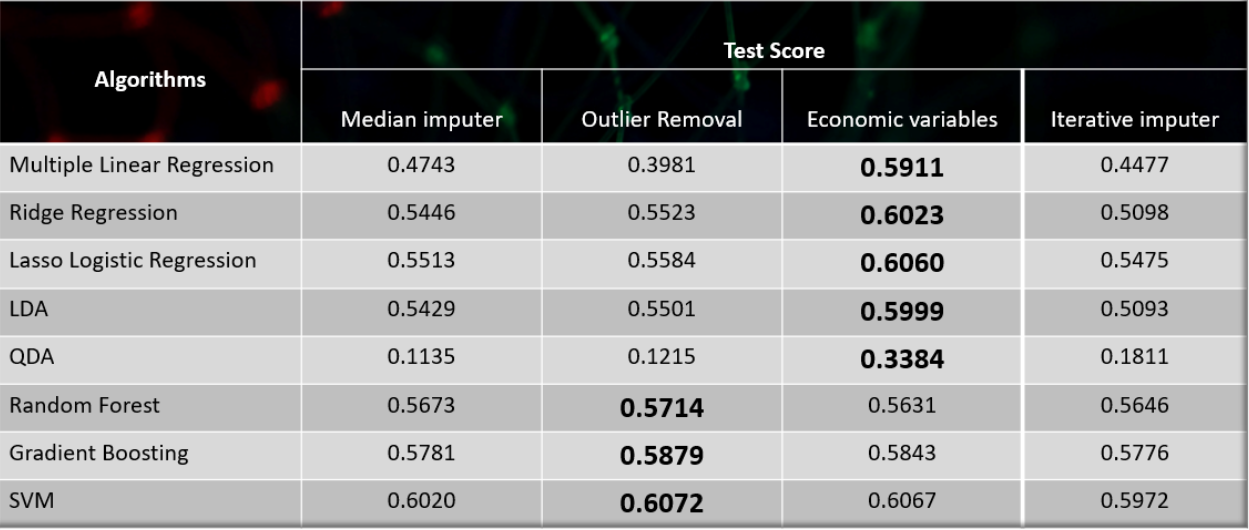

Overall, it is obvious that the issues with the datasets discussed above had a detrimental impact on the precision of our recommendation algorithms. In most of the years our test score was only slightly better than always classifying a stock as the class with the highest occurrences. 

When comparing the different methods of data preparation, we see that the models on the three datasets with sector-wise median imputed values had higher scores than the models on the data prepared with the Random Forest iterative imputer. Hence, the more sophisticated method was not worth the effort. When comparing the median imputed datasets with each other, removing equity premium outliers slightly improved the results for all algorithms except for the Multiple Linear Regression with no penalty. However, these improvements were rather marginal. Adding extra economic indicators was able to improve the test scores more significantly in most cases, thus this way of data preparation resulted in the best prediction performances.

When comparing the used algorithms, it is easier to mark out the two that performed poorly: **Multiple Linear Regression** and **Quadratic Discriminant Analysis (QDA)**. Especially QDA had a bad performance on all datasets. The remaining algorithms achieved performances on the test sets around 55% to 60%. The model with the highest accuracy scores was the hyperparameter fine-tuned **SVM** which got around 60% of test set accuracy among all datasets. **Random Forest** and **Gradient Boosting** achieved slighty inferior accuracies, but still rather robust scores among the different datasets. The **Linear Ridge Classifier**, **Logistic Regression with Lasso penalty** and **Linear Discriminant Analysis** also achieved test scores around 60% for the median imputed data with no outliers and added economic indicators, but got inferior results on the remaining datasets.

The highest test score is achieved with SVM on the sector-wise median imputed dataset with removed equity premium outliers. Therefore, our investment recommendations correspond to the predicted classifications of this model.

## References

* Boser, B. E., Guyon, I. M., & Vapnik, V. N. (1992). A training algorithm for optimalmargin classifiers. *In Proceedings of the fifth annual workshop on Computa-tional learning theory.*
* Breiman, L. (2001). Random forests. *Machine Learning, 45*(1), 5–32.
* Bromley, J., Guyon, I., LeCun, Y., Säckinger, E., & Shah, R. (1993). Signatureverification using a "siamese" time delay neural network. *Advances in neuralinformation processing systems, 6*, 737–744.
* Drucker, H., Burges, C. J., Kaufmann, L., Smola, A., & Vapnik, V. (1997). Support vector regression machines. *Advances in neural information processingsystems, 9*, 155–161.
* Friedman, J., Hastie, T., & Tibshirani, R. (2001). *The Elements of Statistical Learning.* New York: Springer.
* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). *An introduction to statistical learning.* New York: springer.
* Nassirtoussi, A. K., Aghabozorgi, S., Teh, Y. W., & Ngo, D. C. L. (2014). Textmining for market prediction: a systematic review. *Expert Systems with Applications, 41*(16), 7653–7670.
* Ou, P., & Wang, H. (2009). Prediction of Stock Market Index Movement by TenData Mining Techniques. *Modern Applied Science, 3*(12), 28–42.
* Raschka, S., & Mirjalili, V. (2017). *Python machine learning: machine learning and deep learning with Python, scikit-learn, and TensorFlow.* Packt publishingltd.